# Data Analysis for FD003

In [286]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.nonparametric.smoothers_lowess import lowess
import pymannkendall as mk

## Data Preprocessing

In [287]:
train_data_df = pd.read_csv('../../TED/CMAPSSData/train_FD003.txt', sep=' ', header = None)
test_data_df = pd.read_csv('../../TED/CMAPSSData/test_FD003.txt', sep=' ', header = None)
test_labels_at_break_df = pd.read_csv('../../TED/CMAPSSData/RUL_FD003.txt', sep=' ', header = None)

train_data_df.drop(train_data_df.columns[[-1, -2]], axis=1, inplace=True)
test_data_df.drop(test_data_df.columns[[-1, -2]], axis=1, inplace=True)
test_labels_at_break_df.drop(test_labels_at_break_df.columns[[-1]], axis=1, inplace=True)

### Extracting labels and organising the data

In [288]:
column_names = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']

train_data_df.columns = column_names
max_cycles_train_df = train_data_df.groupby(['ID'], sort=False)['Cycle'].max().reset_index().rename(columns={'Cycle':'MaxCycleID'})

train_data_df = pd.merge(train_data_df, max_cycles_train_df, how='inner', on='ID')
train_data_df['RUL'] = train_data_df['MaxCycleID'] - train_data_df['Cycle']
train_data_df.drop(columns=['MaxCycleID'], inplace=True)

test_data_df.columns = column_names
max_cycles_test_df = test_data_df.groupby(['ID'], sort=False)['Cycle'].max().reset_index().rename(columns={'Cycle':'MaxCycleID'})

test_labels_at_break_df.columns = ['RUL']
test_labels_at_break_df['ID'] = max_cycles_test_df['ID']
test_labels_at_break_df['RUL'] = test_labels_at_break_df['RUL'] + max_cycles_test_df['MaxCycleID']

test_data_df = pd.merge(test_data_df, test_labels_at_break_df, how='inner', on='ID')
test_data_df['RUL'] = test_data_df['RUL'] - test_data_df['Cycle']

In [289]:
train_labels_df = train_data_df['RUL']
test_labels_df = test_data_df['RUL']
train_labels_at_break_df = train_data_df.groupby('ID').last().reset_index()['RUL']

### Divide by engine

In [290]:
train_groupby = train_data_df.groupby(['ID'], sort=False)
test_groupby = test_data_df.groupby(['ID'], sort=False)

### Graphs: Data before analysed

In [291]:
sensor_names = []
for i in range(3):
    sensor_names.append('OpSet' + str(i+1))
for i in range(21):
    sensor_names.append('SensorMeasure' + str(i+1))

In [292]:
def divide_by_engine(df_groupby):

    groupby_arr = []
    for i in range(len(df_groupby)):
        groupby_arr.append(df_groupby.get_group(i+1))

    for i in range(len(df_groupby)):
        groupby_arr[i] = groupby_arr[i].to_numpy()

    return groupby_arr

In [293]:
def plot_by_engine(train_gb, rows, names, filename):

    train_groupby_arr = divide_by_engine(train_gb)

    fig, axs = plt.subplots(rows, 4)
    flat_axs = axs.flatten()
    for sensor in range(len(names)):
        flat_axs[sensor].set_title(names[sensor])
        for engine in range(len(train_groupby_arr)):
            flat_axs[sensor].plot(train_groupby_arr[engine][:, 1], train_groupby_arr[engine][:, sensor + 2])

    plt.setp(axs[-1, :], xlabel='Cycles')
    plt.setp(axs[:, 0], ylabel='Sensor readings')
    fig.set_size_inches(20, 30) 
    plt.savefig(filename)
    plt.show()

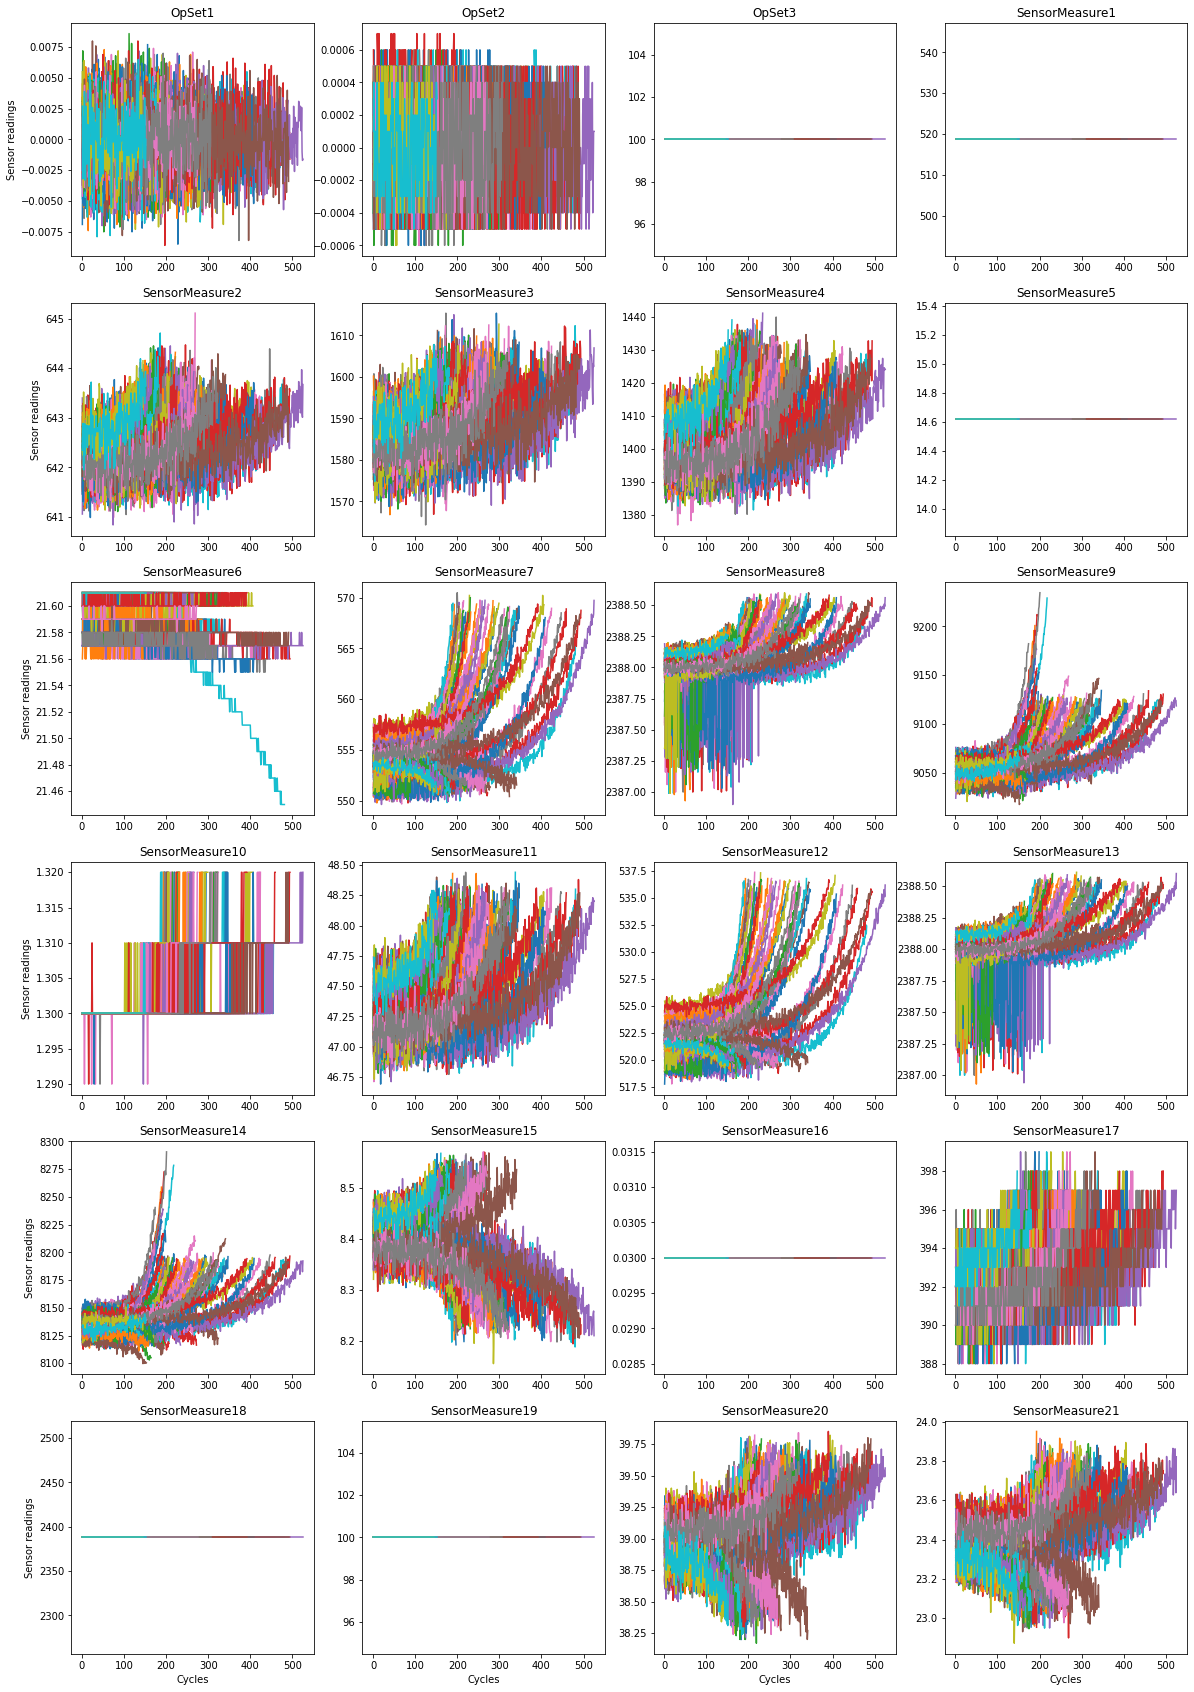

In [294]:
plot_by_engine(train_groupby, 6, sensor_names, 'fd003-sensors_unprocessed.jpg')

From the graph, we can see which sensors will have a greater impact on the performance of the regressor, and which are irrelevant for this task. I decided to take Sensors: 1, 5, 6, 10, 16, 18, 19

### Taking away all non-important sensors

In [295]:
sensors_used = []
sensors_used.append('ID')
sensors_used.append('Cycle')
for i in range(1, 22):
    # if i not in [1, 5, 6, 10, 16, 18, 19]:
    sensors_used.append("SensorMeasure" + str(i))

In [296]:
train_data_df = train_data_df[sensors_used]
train_grouppby = train_data_df.groupby(['ID'], sort=False)
test_groupby = test_data_df.groupby(['ID'], sort=False)

In [297]:
train_data_df

ID  Cycle  SensorMeasure1  SensorMeasure2  SensorMeasure3  \
0        1      1          518.67          642.36         1583.23   
1        1      2          518.67          642.50         1584.69   
2        1      3          518.67          642.18         1582.35   
3        1      4          518.67          642.92         1585.61   
4        1      5          518.67          641.68         1588.63   
...    ...    ...             ...             ...             ...   
24715  100    148          518.67          643.78         1596.01   
24716  100    149          518.67          643.29         1596.38   
24717  100    150          518.67          643.84         1604.53   
24718  100    151          518.67          643.94         1597.56   
24719  100    152          518.67          643.64         1599.04   

       SensorMeasure4  SensorMeasure5  SensorMeasure6  SensorMeasure7  \
0             1396.84           14.62           21.61          553.97   
1             1396.89           14.62           21.61          554.55   
2             1405.61           14.62           21.61          554.43   
3             1392.27           14.62           21.61          555.21   
4             1397.65           14.62           21.61          554.74   
...               ...             ...             ...             ...   
24715         1424.11           14.62           21.61          551.86   
24716         1429.14           14.62           21.61          551.86   
24717         1431.41           14.62           21.61          551.30   
24718         1426.57           14.62           21.61          550.69   
24719         1436.06           14.62           21.61          550.96   

       SensorMeasure8  ...  SensorMeasure12  SensorMeasure13  SensorMeasure14  \
0             2387.96  ...           522.31          2388.01          8145.32   
1             2388.00  ...           522.42          2388.03          8152.85   
2             2388.03  ...           522.03          2388.00          8150.17   
3             2388.00  ...           522.49          2388.08          8146.56   
4             2388.04  ...           522.58          2388.03          8147.80   
...               ...  ...              ...              ...              ...   
24715         2388.25  ...           519.66          2388.30          8138.08   
24716         2388.23  ...           519.91          2388.28          8144.36   
24717         2388.25  ...           519.44          2388.24          8135.95   
24718         2388.26  ...           520.01          2388.26          8141.24   
24719         2388.26  ...           519.48          2388.24          8136.98   

       SensorMeasure15  SensorMeasure16  SensorMeasure17  SensorMeasure18  \
0               8.4246             0.03              391             2388   
1               8.4403             0.03              392             2388   
2               8.3901             0.03              391             2388   
3               8.3878             0.03              392             2388   
4               8.3869             0.03              392             2388   
...                ...              ...              ...              ...   
24715           8.5036             0.03              394             2388   
24716           8.5174             0.03              395             2388   
24717           8.5223             0.03              396             2388   
24718           8.5148             0.03              395             2388   
24719           8.5150             0.03              396             2388   

       SensorMeasure19  SensorMeasure20  SensorMeasure21  
0                100.0            39.11          23.3537  
1                100.0            38.99          23.4491  
2                100.0            38.85          23.3669  
3                100.0            38.96          23.2951  
4                100.0            39.14          23.4583  
...                ...              ...           

### Principal Component Analysis

In [298]:
train_data_df.shape
ms_used = sensors_used[2:]

In [299]:
sc = StandardScaler()
scaled_values = sc.fit_transform(train_data_df.values[:, 2:])

pca = PCA(n_components = 0.99)
pca_values = pca.fit_transform(scaled_values)

Number of components: 12


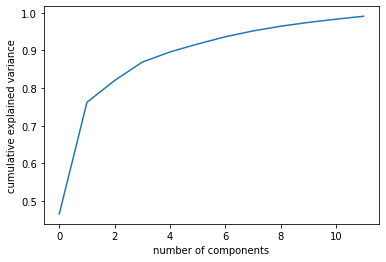

In [300]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print("Number of components: " + str(pca.n_components_))

In [301]:
pd.DataFrame(pca.components_, columns = ms_used)

SensorMeasure1  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0             -0.0        0.200710        0.245867        0.229412   
1              0.0        0.290542        0.229307        0.295427   
2              0.0        0.037667        0.007345        0.047711   
3             -0.0        0.216022        0.119007        0.207725   
4              0.0        0.306026       -0.107294        0.175385   
5             -0.0       -0.352067        0.874471       -0.012310   
6              0.0        0.709990        0.159641       -0.154345   
7             -0.0        0.280479        0.247921       -0.325141   
8             -0.0       -0.141086       -0.079430        0.581580   
9             -0.0       -0.003849        0.006582        0.011272   
10             0.0       -0.078815       -0.054951       -0.550116   
11             0.0       -0.017874       -0.006874       -0.091756   

    SensorMeasure5  SensorMeasure6  SensorMeasure7  SensorMeasure8  \
0    -0.000000e+00        0.023392        0.301256        0.311781   
1     1.110223e-16        0.269985       -0.243591        0.089979   
2     1.601367e-16       -0.422232       -0.088439       -0.347831   
3     2.220446e-16       -0.705083        0.009898       -0.064056   
4    -7.632783e-17        0.453169        0.110082       -0.445686   
5     1.040834e-16        0.077090        0.005107       -0.129241   
6    -8.326673e-17       -0.055139       -0.001661        0.091120   
7     4.857226e-17        0.029150        0.019441       -0.178176   
8    -1.318390e-16       -0.011857        0.093844       -0.091384   
9     5.551115e-17        0.004933        0.007770       -0.004686   
10   -8.326673e-17        0.018277        0.078649       -0.027181   
11    0.000000e+00       -0.169871       -0.129363        0.038342   

    SensorMeasure9  SensorMeasure10  ...  SensorMeasure12  SensorMeasure13  \
0         0.295825         0.293134  ...         0.305762         0.311777   
1         0.030743        -0.151299  ...        -0.235916         0.089512   
2         0.495933         0.010017  ...        -0.084434        -0.348630   
3        -0.340322         0.215195  ...         0.013610        -0.064012   
4        -0.083526         0.401107  ...         0.112995        -0.445639   
5        -0.045164         0.060264  ...         0.006034        -0.132079   
6         0.032768        -0.220387  ...        -0.004825         0.086653   
7        -0.060614        -0.395469  ...         0.019738        -0.177242   
8        -0.003698        -0.651820  ...         0.097204        -0.089085   
9        -0.002964        -0.043164  ...         0.012361        -0.008430   
10        0.019009        -0.141019  ...         0.077135        -0.033498   
11        0.028350         0.082534  ...        -0.125987         0.042174   

    SensorMeasure14  SensorMeasure15  SensorMeasure16  SensorMeasure17  \
0          0.281669        -0.173152    -8.936315e-32         0.252950   
1         -0.020283         0.377975    -2.465190e-32         0.240307   
2          0.531691         0.021940    -5.293956e-23         0.010611   
3         -0.393096        -0.100328    -0.000000e+00         0.105758   
4         -0.104542         0.015233     0.000000e+00        -0.065692   
5         -0.037987        -0.002033    -0.000000e+00        -0.250829   
6          0.046536        -0.049116    -1.734723e-18        -0.593616   
7         -0.048883        -0.097901    -1.387779e-17         0.645251   
8         -0.027195        -0.100545     1.110223e-16        -0.141672   
9         -0.009082        -0.022706    -2.775558e-17         0.019093   
10        -0.008932        -0.114861    -1.110223e-16        -0.097324   
11         0.014936         0.744064     5.551115e-17        -0.027414   

    SensorMeasure18  SensorMeasure19  SensorMeasure20  SensorMeasure21  
0              -0.0    -0.000000e+00         0.165527         0.167765  
1               0.0     0.000000e+00        -0.369363     

In [302]:
n_pcs = pca.n_components_
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = ms_used
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

print(most_important_names)

['SensorMeasure8', 'SensorMeasure15', 'SensorMeasure14', 'SensorMeasure6', 'SensorMeasure6', 'SensorMeasure3', 'SensorMeasure2', 'SensorMeasure17', 'SensorMeasure10', 'SensorMeasure21', 'SensorMeasure11', 'SensorMeasure15']


In [303]:
fig = px.scatter_3d(pca_values, x=0, y=1, z=2, color=train_data_df['ID'])
fig.show()
fig.write_html("fd003-PCA-3d_plot.html")

Sensors 2, 3, 4, 6, 7, 11, 12, 13, 14, 15, 17, 21 contribute the most to each of the components of the PCA, so they could have value towards the performance of the algorithm.

### Feature Selection using Mann-Kendall method

<function matplotlib.pyplot.show(close=None, block=None)>

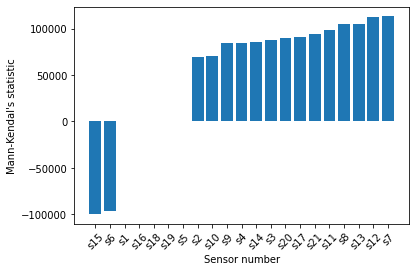

In [304]:
# PyMannKendall test: Code by Zhan Liang, Chan - https://github.com/cchanzl/survival-analysis-nasa/blob/main/nasa_eda.ipynb
avg_cycle = []
for i in range(1, 101):
    df_engine = train_data_df[train_data_df['ID'] == i]
    max_cycle = df_engine.loc[df_engine['Cycle'].idxmax()]
    avg_cycle.append(max_cycle["Cycle"].astype(int))

no_columns = 21
up_sensor_values = np.empty([max(avg_cycle), no_columns]) # 26 sensors with a max cycle of 362
lo_sensor_values = np.empty([max(avg_cycle), no_columns]) # 26 sensors with a max cycle of 362
for col in range(0, no_columns):
    sensor = 'SensorMeasure'
    sensor = sensor + str(col+1)
    for row in range(0, max(avg_cycle)):
        df_train_sens = train_data_df[train_data_df['Cycle'] == row+1]
        
        # find max and min value of a sensor for each cycle
        max_value = df_train_sens.loc[df_train_sens[sensor].idxmax()]
        min_value = df_train_sens.loc[df_train_sens[sensor].idxmin()]
        
        # store max and min value
        up_sensor_values[row, col] = max_value[sensor]
        lo_sensor_values[row, col] = min_value[sensor]
mean_trend = (up_sensor_values + lo_sensor_values)/2

mono = []
def MannKendall(sensor_number, mean_trend, p_value=False):
    sensor_number -= 1
    trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test([row[sensor_number] for row in mean_trend], alpha=0.05)
    if p_value:
        print("{:e}".format(var_s))
    return s

# make x label for graphing
sensor_header = []
for i in range(0, 21):
    name = "s"
    name = name + str(i+1)
    sensor_header.append(name)

# retrieve y axis reading
for i in range(1, no_columns+1):
    mono.append(MannKendall(i, mean_trend))

y,x = zip(*sorted(zip(mono,sensor_header)))
plt.bar(x, y)
plt.xlabel("Sensor number")
plt.ylabel("Mann-Kendal's statistic")
plt.xticks(rotation=45)
plt.show

According to the PyMannKendall test, the most useful sensors would be 2, 3, 4, 7, 8, 11, 12, 13, 15, 17, 20, 21. I will follow Zhan's decision on feature selection.

In [305]:
# train_data_df.to_csv('./fd003-raw_train.csv', sep=' ', columns=train_data_df.columns, index=False)
# test_data_df[train_data_df.columns].to_csv('./fd003-raw_test.csv', sep=' ', columns=train_data_df.columns, index=False)

In [306]:
train_labels_df.to_csv('./fd003-training_labels.csv', sep=' ', columns=['RUL'], index=False)
test_labels_df.to_csv('./fd003-testing_labels.csv', sep=' ', columns=['RUL'], index=False)
train_labels_at_break_df.to_csv('./fd003-testing_labels_at_break.csv', sep=' ', columns=['RUL'], index=False)

In [307]:
sensors_used = []
sensors_used.append('ID')
sensors_used.append('Cycle')
for i in range(1, 22):
    if i not in [1, 5, 16, 18, 19]:
    # if i not in [1, 5, 6, 9, 10, 14, 16, 18, 19]:
        sensors_used.append("SensorMeasure" + str(i))
ms_used = sensors_used[2:]

### Scaling and Normalising Data

In [308]:
train_data_df = train_data_df[sensors_used]
test_data_df = test_data_df[sensors_used]

In [309]:
train_data_df

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0        1      1          642.36         1583.23         1396.84   
1        1      2          642.50         1584.69         1396.89   
2        1      3          642.18         1582.35         1405.61   
3        1      4          642.92         1585.61         1392.27   
4        1      5          641.68         1588.63         1397.65   
...    ...    ...             ...             ...             ...   
24715  100    148          643.78         1596.01         1424.11   
24716  100    149          643.29         1596.38         1429.14   
24717  100    150          643.84         1604.53         1431.41   
24718  100    151          643.94         1597.56         1426.57   
24719  100    152          643.64         1599.04         1436.06   

       SensorMeasure6  SensorMeasure7  SensorMeasure8  SensorMeasure9  \
0               21.61          553.97         2387.96         9062.17   
1               21.61          554.55         2388.00         9061.78   
2               21.61          554.43         2388.03         9070.23   
3               21.61          555.21         2388.00         9064.57   
4               21.61          554.74         2388.04         9076.14   
...               ...             ...             ...             ...   
24715           21.61          551.86         2388.25         9070.82   
24716           21.61          551.86         2388.23         9064.60   
24717           21.61          551.30         2388.25         9063.45   
24718           21.61          550.69         2388.26         9062.22   
24719           21.61          550.96         2388.26         9066.52   

       SensorMeasure10  SensorMeasure11  SensorMeasure12  SensorMeasure13  \
0                  1.3            47.30           522.31          2388.01   
1                  1.3            47.23           522.42          2388.03   
2                  1.3            47.22           522.03          2388.00   
3                  1.3            47.24           522.49          2388.08   
4                  1.3            47.15           522.58          2388.03   
...                ...              ...              ...              ...   
24715              1.3            48.27           519.66          2388.30   
24716              1.3            48.13           519.91          2388.28   
24717              1.3            48.18           519.44          2388.24   
24718              1.3            48.05           520.01          2388.26   
24719              1.3            48.12           519.48          2388.24   

       SensorMeasure14  SensorMeasure15  SensorMeasure17  SensorMeasure20  \
0              8145.32           8.4246              391            39.11   
1              8152.85           8.4403              392            38.99   
2              8150.17           8.3901              391            38.85   
3              8146.56           8.3878              392            38.96   
4              8147.80           8.3869              392            39.14   
...                ...              ...              ...              ...   
24715          8138.08           8.5036              394            38.44   
24716          8144.36           8.5174              395            38.50   
24717          8135.95           8.5223              396            38.39   
24718          8141.24           8.5148              395            38.31   
24719          8136.98           8.5150              396            38.56   

       SensorMeasure21  
0              23.3537  
1              23.4491  
2              23.3669  
3              23.2951  
4              23.4583  
...                ...  
24715          22.9631  
24716          22.9746  
24717          23.0682  
24718          23.0753  
24719          23.0847  

[24720 rows x 18 columns]

In [310]:
train_data_df.to_csv('./fd003-raw_train.csv', sep=' ', columns=train_data_df.columns, index=False)
test_data_df.to_csv('./fd003-raw_test.csv', sep=' ', columns=train_data_df.columns, index=False)

In [311]:
sc = StandardScaler()
for sensor in ms_used:
    train_data_df.loc[:,sensor] = sc.fit_transform(train_data_df[sensor].values.reshape(-1, 1))
    test_data_df.loc[:,sensor] = sc.fit_transform(test_data_df[sensor].values.reshape(-1, 1))

/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [312]:
train_data_df

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0        1      1       -0.187102       -0.712038       -0.780848   
1        1      2        0.080574       -0.497656       -0.775732   
2        1      3       -0.531256       -0.841254        0.116524   
3        1      4        0.883602       -0.362566       -1.248464   
4        1      5       -1.487242        0.080881       -0.697966   
...    ...    ...             ...             ...             ...   
24715  100    148        2.527897        1.164537        2.009498   
24716  100    149        1.591031        1.218867        2.524183   
24717  100    150        2.642615        2.415587        2.756456   
24718  100    151        2.833812        1.392134        2.261213   
24719  100    152        2.260221        1.609453        3.232257   

       SensorMeasure6  SensorMeasure7  SensorMeasure8  SensorMeasure9  \
0            0.781589       -0.341494       -0.704785       -0.097138   
1            0.781589       -0.172755       -0.452071       -0.116658   
2            0.781589       -0.207667       -0.262536        0.306267   
3            0.781589        0.019257       -0.452071        0.022983   
4            0.781589       -0.117479       -0.199357        0.602065   
...               ...             ...             ...             ...   
24715        0.781589       -0.955353        1.127391        0.335797   
24716        0.781589       -0.955353        1.001034        0.024484   
24717        0.781589       -1.118272        1.127391       -0.033074   
24718        0.781589       -1.295739        1.190569       -0.094636   
24719        0.781589       -1.217188        1.190569        0.120581   

       SensorMeasure10  SensorMeasure11  SensorMeasure12  SensorMeasure13  \
0            -0.353479        -0.385602        -0.227593        -0.389857   
1            -0.353479        -0.618882        -0.193802        -0.263369   
2            -0.353479        -0.652208        -0.313608        -0.453101   
3            -0.353479        -0.585556        -0.172298         0.052852   
4            -0.353479        -0.885488        -0.144650        -0.263369   
...                ...              ...              ...              ...   
24715        -0.353479         2.846998        -1.041663         1.444222   
24716        -0.353479         2.380437        -0.964864         1.317734   
24717        -0.353479         2.547066        -1.109246         1.064758   
24718        -0.353479         2.113831        -0.934145         1.191246   
24719        -0.353479         2.347112        -1.096959         1.064758   

       SensorMeasure14  SensorMeasure15  SensorMeasure17  SensorMeasure20  \
0             0.067687         0.469741        -0.889364         0.488019   
1             0.523946         0.729201        -0.321641         0.005819   
2             0.361559        -0.100409        -0.889364        -0.556747   
3             0.142821        -0.138419        -0.321641        -0.114730   
4             0.217955        -0.153292        -0.321641         0.608569   
...                ...              ...              ...              ...   
24715        -0.371001         1.775302         0.813805        -2.204262   
24716         0.009518         2.003362         1.381528        -1.963162   
24717        -0.500062         2.084340         1.949251        -2.405178   
24718        -0.179530         1.960394         1.381528        -2.726644   
24719        -0.437652         1.963699         1.949251        -1.722062   

       SensorMeasure21  
0            -0.263512  
1             0.375767  
2            -0.175058  
3            -0.656192  
4             0.437416  
...                ...  
24715        -2.880934  
24716        -2.803872  
24717        -2.176656  
24718        -2.129079  
24719        -2.066089  

[24720 rows x 18 columns]

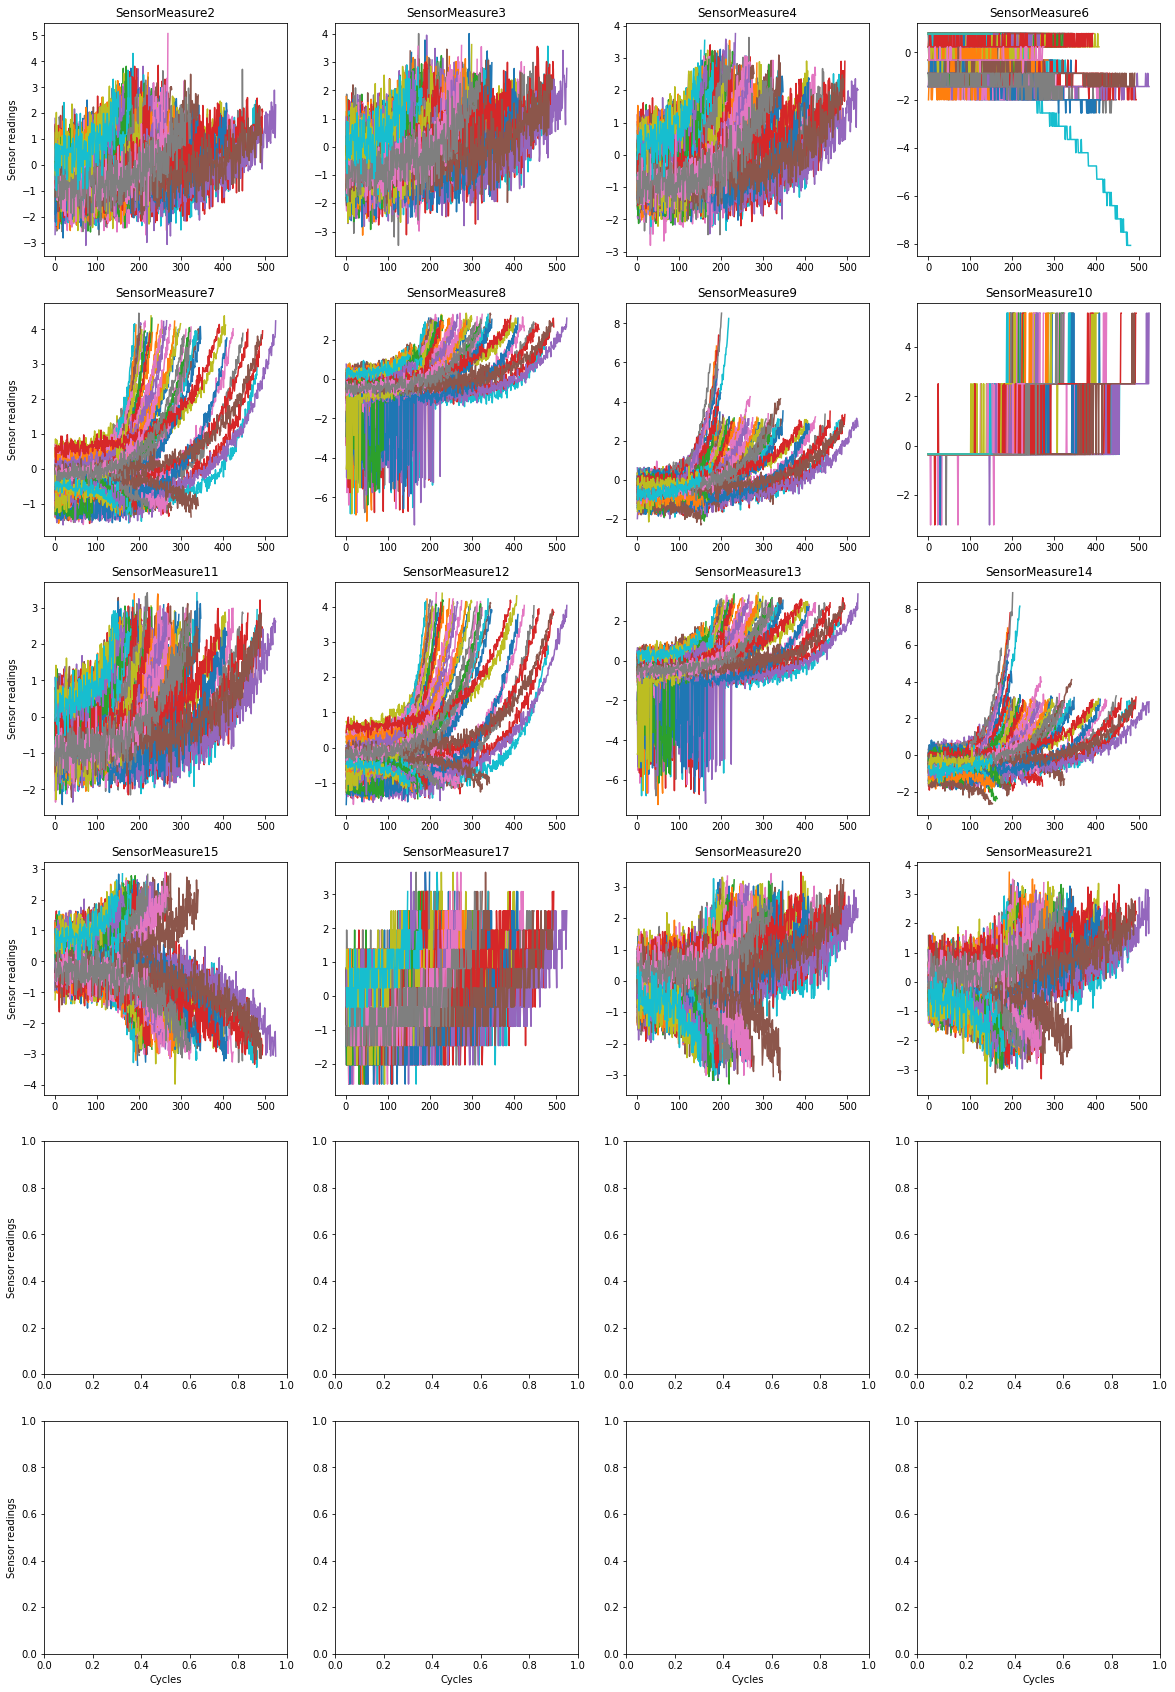

In [313]:
train_groupby = train_data_df.groupby(['ID'], sort=False)
plot_by_engine(train_groupby, 6, ms_used, 'fd003-sensors_scaled.jpg')

In [314]:
train_data_df.to_csv('./fd003-scaled_train.csv', sep=' ', columns=train_data_df.columns, index=False)
test_data_df.to_csv('./fd003-scaled_test.csv', sep=' ', columns=train_data_df.columns, index=False)

### Smoothing curves

In [315]:
train_groupby = train_groupby[['ID', 'Cycle'] + ms_used]
test_groupby = test_groupby[['ID', 'Cycle'] + ms_used]
train_groupby.get_group(1)

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0     1      1       -0.187102       -0.712038       -0.780848   
1     1      2        0.080574       -0.497656       -0.775732   
2     1      3       -0.531256       -0.841254        0.116524   
3     1      4        0.883602       -0.362566       -1.248464   
4     1      5       -1.487242        0.080881       -0.697966   
..   ..    ...             ...             ...             ...   
254   1    255        1.801348        1.731327        2.397302   
255   1    256        2.642615        1.649099        1.970616   
256   1    257        2.030784        1.951583        2.126146   
257   1    258        2.298460        2.748907        2.750316   
258   1    259        2.833812        1.682871        3.055239   

     SensorMeasure6  SensorMeasure7  SensorMeasure8  SensorMeasure9  \
0          0.781589       -0.341494       -0.704785       -0.097138   
1          0.781589       -0.172755       -0.452071       -0.116658   
2          0.781589       -0.207667       -0.262536        0.306267   
3          0.781589        0.019257       -0.452071        0.022983   
4          0.781589       -0.117479       -0.199357        0.602065   
..              ...             ...             ...             ...   
254        0.781589       -0.888439        1.316926        0.675138   
255        0.781589       -1.013538        0.748320        0.326788   
256        0.781589       -1.077542        1.316926        0.713177   
257        0.781589       -0.952443        1.316926        1.040005   
258        0.781589       -1.030994        1.127391        0.610073   

     SensorMeasure10  SensorMeasure11  SensorMeasure12  SensorMeasure13  \
0          -0.353479        -0.385602        -0.227593        -0.389857   
1          -0.353479        -0.618882        -0.193802        -0.263369   
2          -0.353479        -0.652208        -0.313608        -0.453101   
3          -0.353479        -0.585556        -0.172298         0.052852   
4          -0.353479        -0.885488        -0.144650        -0.263369   
..               ...              ...              ...              ...   
254        -0.353479         2.747021        -0.845058         0.938269   
255        -0.353479         2.113831        -0.971008         0.938269   
256        -0.353479         2.480415        -1.026304         1.191246   
257        -0.353479         2.313786        -1.023232         0.875025   
258        -0.353479         3.080278        -1.109246         1.001514   

     SensorMeasure14  SensorMeasure15  SensorMeasure17  SensorMeasure20  \
0           0.067687         0.469741        -0.889364         0.488019   
1           0.523946         0.729201        -0.321641         0.005819   
2           0.361559        -0.100409        -0.889364        -0.556747   
3           0.142821        -0.138419        -0.321641        -0.114730   
4           0.217955        -0.153292        -0.321641         0.608569   
..               ...              ...              ...              ...   
254        -0.055921         2.011625         0.813805        -2.405178   
255         0.420333         1.811659         2.516973        -2.123895   
256         0.312479         2.224812         3.084696        -2.525728   
257         0.407003         1.628220         1.949251        -2.003345   
258         0.299755         2.233075         3.084696        -2.565911   

     SensorMeasure21  
0          -0.263512  
1           0.375767  
2          -0.175058  
3          -0.656192  
4           0.437416  
..               ...  
254        -2.153872  
255        -2.306656  
256        -1.924697  
257        -2.192738  
258        -2.159903  

[259 rows x 18 columns]

In [316]:
smoothing_columns = ['ID', 'Cycle'] + ms_used
train_groupby_arr = []
for i in range(len(train_groupby)):
    df = train_groupby.get_group(i+1).copy()
    lowess_df = df.copy()
    for sensor in range(2, len(smoothing_columns)):
        sn = smoothing_columns[sensor]
        lowess_df[sn] = pd.DataFrame(lowess(df[sn], np.arange(len(df[sn])), frac=0.25)[:, 1], index=df.index, columns=[sn])
    train_groupby_arr.append(lowess_df)

tr_joined_lowess_df = train_groupby_arr[0]
for i in range(1, len(train_groupby_arr)):
    tr_joined_lowess_df = pd.concat([tr_joined_lowess_df, train_groupby_arr[i]])

test_groupby_arr = []
for i in range(len(test_groupby)):
    df = test_groupby.get_group(i+1).copy()
    lowess_df = df.copy()
    for sensor in range(2, len(smoothing_columns)):
        sn = smoothing_columns[sensor]
        lowess_df[sn] = pd.DataFrame(lowess(df[sn], np.arange(len(df[sn])), frac=0.25)[:, 1], index=df.index, columns=[sn])
    test_groupby_arr.append(lowess_df)

test_joined_lowess_df = test_groupby_arr[0]
for i in range(1, len(test_groupby_arr)):
    test_joined_lowess_df = pd.concat([test_joined_lowess_df, test_groupby_arr[i]])

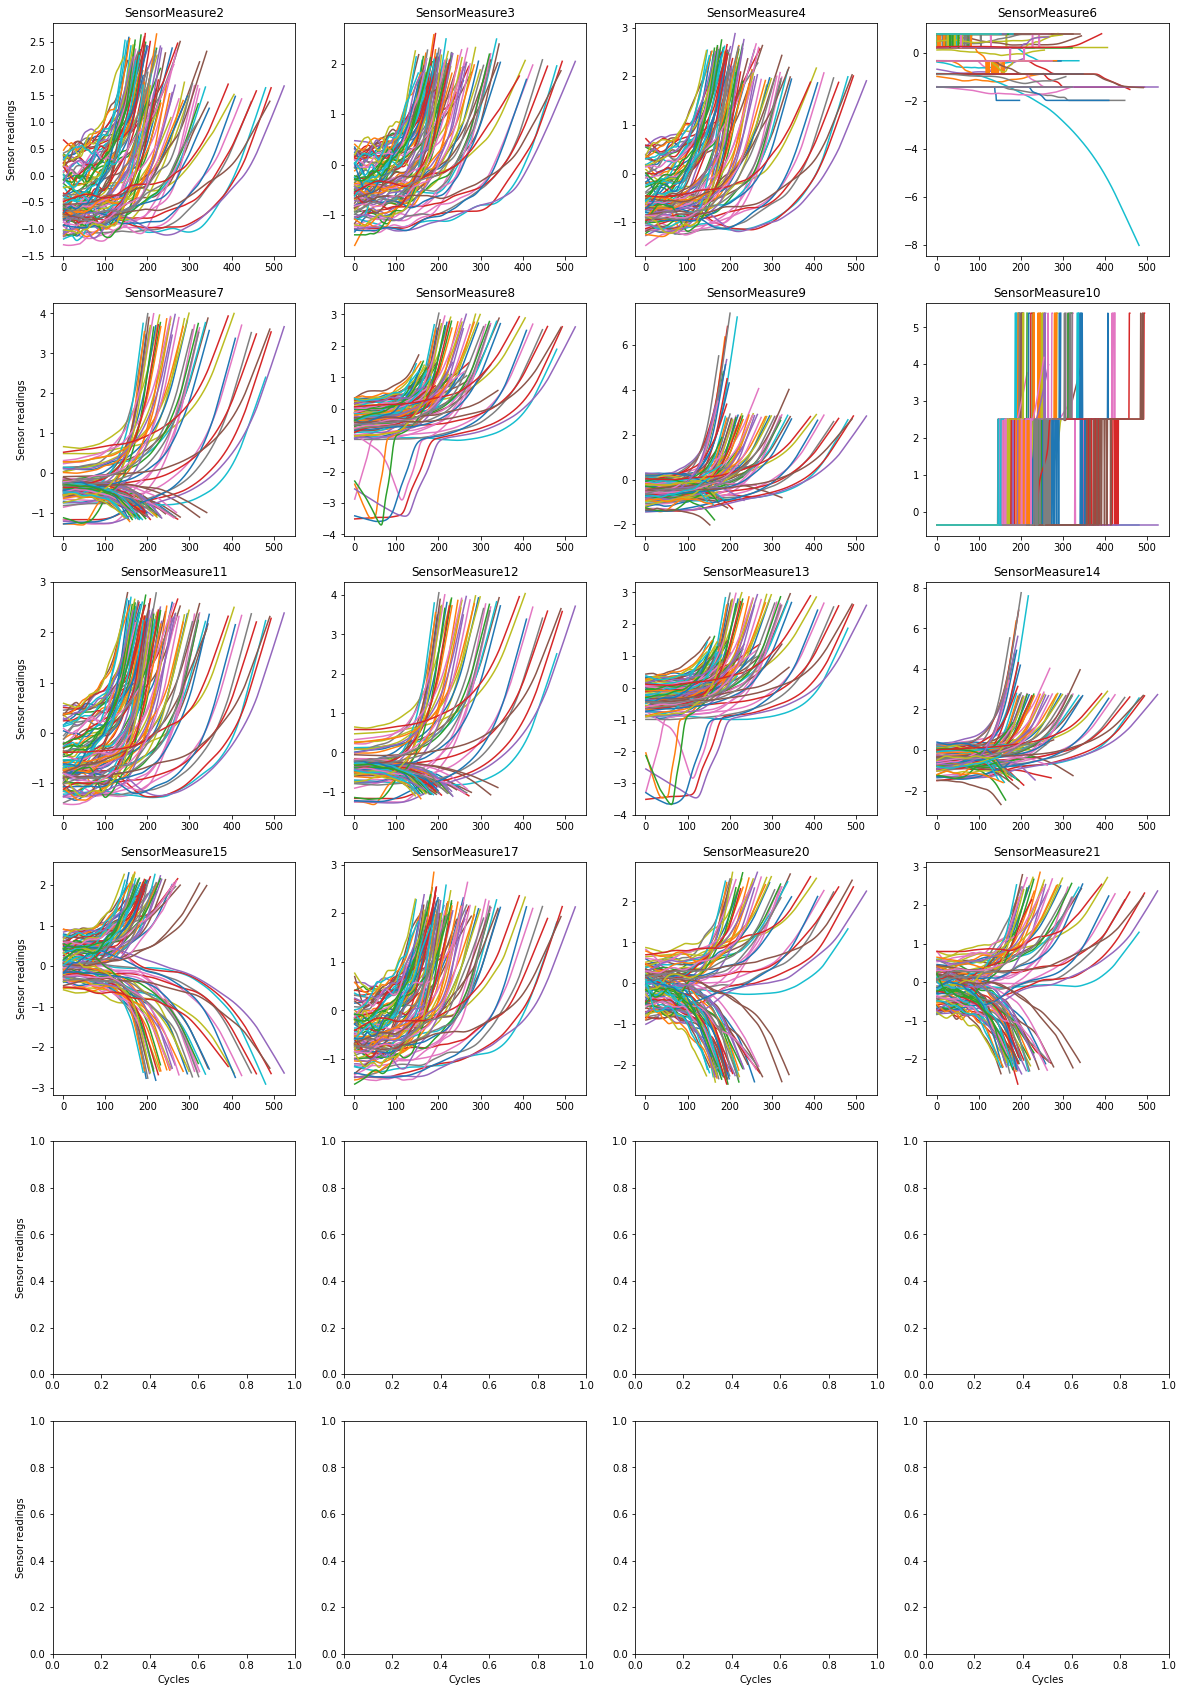

In [317]:
tr_joined_lowess_groupby = tr_joined_lowess_df.groupby(['ID'], sort = False)
plot_by_engine(tr_joined_lowess_groupby, 6, ms_used, 'fd003-sensors_smoothed.jpg')

In [318]:
tr_joined_lowess_df.to_csv('./fd003-smoothed_train.csv', sep=' ', columns=tr_joined_lowess_df.columns, index=False)
test_joined_lowess_df.to_csv('./fd003-smoothed_test.csv', sep=' ', columns=test_joined_lowess_df.columns, index=False)